In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pickle
import MeCab

In [2]:
# 1月から12月までのデータを読み込んで結合しdfに格納
df = pd.DataFrame()
for i in range(1, 13):
    df_tmp = pd.read_csv(f"../data_collection/data/2020-{i:02}.csv", encoding="utf8")
    df = pd.concat([df, df_tmp], ignore_index=True)
df.head()

,likes_count,title,body,created_date,created_time,tags,followers_count,organization,items_count
0,1.0,品質担保に本気で取り組んでみている話,株式会社オズビジョンの @terra_yucco です。2020/01 現在、オズビジョン ...,2020-01-31,23:59:59,"['仕様', '品質管理', '品質', 'QCD']",43.0,OZvision Inc.,97.0
1,5.0,【Unity】Screen.safeAreaとiOSステータスバーの罠（？）,# Unityで取得できる Screen.safeAreaには罠（？）がある罠に遭遇したのは...,2020-01-31,23:56:36,"['iOS', 'Unity', 'SafeArea']",2.0,NaN,7.0
2,3.0,徹底攻略！“SATySFiのロゴ”の出し方,**SATySFiのロゴ**といえば、もちろんコレですね。![image-1a.png](h...,2020-01-31,23:54:15,['SATySFi'],157.0,NaN,65.0
3,0.0,【KPI】家系図テーブルの操作 1【oracle】,某炎の紋章の家系図見てて、TRPGなどに使えるかなと思って家系図テーブルの運用を考える。階層...,2020-01-31,23:50:44,['oracle'],1.0,NaN,10.0
4,0.0,プログラミング・フォロを組み立てる,#プログラミング・フォロmicro:bitを内蔵して６本足で自律して歩き回ることの出来る [...,2020-01-31,23:45:47,"['RaspberryPi', 'microbit']",3.0,NaN,11.0


In [3]:
# dfの各カラムのデータ型を確認
df.dtypes

likes_count        float64
title               object
body                object
created_date        object
created_time        object
tags                object
followers_count    float64
organization        object
items_count        float64
dtype: object

In [4]:
# dfの各カラムの欠損値の数を確認
df.isnull().sum()

likes_count             1
title                   0
body                    1
created_date            1
created_time            1
tags                    1
followers_count         2
organization       110525
items_count             2
dtype: int64

In [5]:
# organizationに値が入っていればTrue、欠損していればFalseに置き換える
df["organization"] = df["organization"].notnull()
df.head()

,likes_count,title,body,created_date,created_time,tags,followers_count,organization,items_count
0,1.0,品質担保に本気で取り組んでみている話,株式会社オズビジョンの @terra_yucco です。2020/01 現在、オズビジョン ...,2020-01-31,23:59:59,"['仕様', '品質管理', '品質', 'QCD']",43.0,True,97.0
1,5.0,【Unity】Screen.safeAreaとiOSステータスバーの罠（？）,# Unityで取得できる Screen.safeAreaには罠（？）がある罠に遭遇したのは...,2020-01-31,23:56:36,"['iOS', 'Unity', 'SafeArea']",2.0,False,7.0
2,3.0,徹底攻略！“SATySFiのロゴ”の出し方,**SATySFiのロゴ**といえば、もちろんコレですね。![image-1a.png](h...,2020-01-31,23:54:15,['SATySFi'],157.0,False,65.0
3,0.0,【KPI】家系図テーブルの操作 1【oracle】,某炎の紋章の家系図見てて、TRPGなどに使えるかなと思って家系図テーブルの運用を考える。階層...,2020-01-31,23:50:44,['oracle'],1.0,False,10.0
4,0.0,プログラミング・フォロを組み立てる,#プログラミング・フォロmicro:bitを内蔵して６本足で自律して歩き回ることの出来る [...,2020-01-31,23:45:47,"['RaspberryPi', 'microbit']",3.0,False,11.0


In [6]:
# 欠損値を含む行を削除
df = df.dropna()
# indexを振り直す
df = df.reset_index(drop=True)

In [7]:
# likes_countの値が1000以上の行を抽出
df[df["likes_count"] >= 1000].head()

,likes_count,title,body,created_date,created_time,tags,followers_count,organization,items_count
749,1386.0,Vue開発者のためのVue.jsベストプラクティス集15選,# はじめに**みなさん、Vue使ってますかー！**・・・・・・・（へんじがない。ただのしか...,2020-01-29,23:00:56,"['JavaScript', 'Vue.js', 'Nuxt']",131.0,False,15.0
1008,1523.0,Vue.jsで作成された、ちょっと面白くて役立ちそうなサービス,## [こちらに移行しました。(2020/05/16)](https://tech-blog...,2020-01-29,08:43:49,"['JavaScript', 'Bootstrap', 'ツール', 'Vue.js', '...",35.0,False,19.0
1459,1024.0,FFT（高速フーリエ変換）を完全に理解する話,"FFT(Fast Fourier Transform),高速フーリエ変換についての記事です。...",2020-01-27,22:00:06,"['アルゴリズム', 'math', 'AtCoder', '競技プログラミング']",163.0,False,28.0
3500,1062.0,2020年現在 Web系企業で採用されてる技術についてまとめてみた,# はじめに2020年も始まりましたね！タイトル通りですが、2020年現在スタートアップや大...,2020-01-22,10:43:23,"['初心者', 'ツール', 'まとめ', '初心者向け', 'プログラミング言語']",24.0,False,27.0
3868,4834.0,良いコードの書き方,# 概要チームによる継続的開発を前提としたコーディングのガイドライン。特定の言語を対象とした...,2020-01-21,10:50:39,"['Java', 'プログラミング', 'コーディング規約', 'チーム開発', 'Swift']",128.0,True,29.0


In [8]:
# likes_countの値が1000以上なら1000に置き換える
df.loc[df["likes_count"] >= 1000, "likes_count"] = 1000
df[df["likes_count"] >= 1000].head()

,likes_count,title,body,created_date,created_time,tags,followers_count,organization,items_count
749,1000.0,Vue開発者のためのVue.jsベストプラクティス集15選,# はじめに**みなさん、Vue使ってますかー！**・・・・・・・（へんじがない。ただのしか...,2020-01-29,23:00:56,"['JavaScript', 'Vue.js', 'Nuxt']",131.0,False,15.0
1008,1000.0,Vue.jsで作成された、ちょっと面白くて役立ちそうなサービス,## [こちらに移行しました。(2020/05/16)](https://tech-blog...,2020-01-29,08:43:49,"['JavaScript', 'Bootstrap', 'ツール', 'Vue.js', '...",35.0,False,19.0
1459,1000.0,FFT（高速フーリエ変換）を完全に理解する話,"FFT(Fast Fourier Transform),高速フーリエ変換についての記事です。...",2020-01-27,22:00:06,"['アルゴリズム', 'math', 'AtCoder', '競技プログラミング']",163.0,False,28.0
3500,1000.0,2020年現在 Web系企業で採用されてる技術についてまとめてみた,# はじめに2020年も始まりましたね！タイトル通りですが、2020年現在スタートアップや大...,2020-01-22,10:43:23,"['初心者', 'ツール', 'まとめ', '初心者向け', 'プログラミング言語']",24.0,False,27.0
3868,1000.0,良いコードの書き方,# 概要チームによる継続的開発を前提としたコーディングのガイドライン。特定の言語を対象とした...,2020-01-21,10:50:39,"['Java', 'プログラミング', 'コーディング規約', 'チーム開発', 'Swift']",128.0,True,29.0


# 変更ここから
全てのデータを結合するのをやめる

* title	-> TF-IDF
* body -> TF-IDF
* created_date -> ~~何日前に作成されたかに変更~~ 削除
* created_time -> ~~何時に作成されたかに変更~~ 削除
* tags -> タグの数とタグのTF-IDF
* followers_count
* organization -> 所属しているかどうか
* items_count

In [9]:
df = df.drop(["created_date", "created_time"], axis=1)

In [10]:
# この状態で一旦保存
# df.to_csv("data/df_base.csv", index=False)

In [11]:
# 分かち書き
wakati = MeCab.Tagger("-Owakati")

def wakati_process(x):
    # 入力の文字列を句点で区切る
    sentences = x.split('。')

    # 分かち書きできる文章だけを集める
    wakati_sentences = []
    for sentence in sentences:
        try:
            wakati_sentence = ' '.join(wakati.parse(sentence).split())
            if wakati_sentence:
                wakati_sentences.append(wakati_sentence)
        except:
            # 例外が発生した場合は何もしない
            pass

    # 集めた分かち書きできる文章を再度文章に復元する
    return ' 。 '.join(wakati_sentences)

In [12]:
df['body_wakati'] = df['body'].apply(wakati_process)
df['title_wakati'] = df['title'].apply(wakati_process)

In [13]:
def tags_process(x):
    x = eval(x)
    return ' '.join(x)


df['tags_wakati'] = df['tags'].apply(tags_process)

In [14]:
# 文の情報をTF-IDFでベクトル化してからSVDで10次元に削減する関数
def vectorize_text(text, n_components=10):
    tfidf = TfidfVectorizer()
    df_tfidf = tfidf.fit_transform(df[text])
    pickle.dump(tfidf, open(f"output_mecab/tfidf_{text}.pkl", "wb"))
    svd = TruncatedSVD(n_components=n_components)
    df_svd = svd.fit_transform(df_tfidf)
    pickle.dump(svd, open(f"output_mecab/svd_{text}.pkl", "wb"))
    df_ret = pd.DataFrame(df_svd, columns=[f"{text}_{i}" for i in range(n_components)])
    return df_ret

In [15]:
# 指定のカラムをベクトル化して結合
for col, n_components in [("title_wakati", 20), ("body_wakati", 20), ("tags_wakati", 20)]:
    df_vec = vectorize_text(col, n_components)
    # ベクトル化したカラムを結合
    df = pd.concat([df, df_vec], axis=1)
    # 欠損値を含む行を削除
    df = df.dropna()
    # 元のカラムを削除
    df = df.drop(col, axis=1)
df.head()

,likes_count,title,body,tags,followers_count,organization,items_count,title_wakati_0,title_wakati_1,title_wakati_2,...,tags_wakati_10,tags_wakati_11,tags_wakati_12,tags_wakati_13,tags_wakati_14,tags_wakati_15,tags_wakati_16,tags_wakati_17,tags_wakati_18,tags_wakati_19
0,1.0,品質担保に本気で取り組んでみている話,株式会社オズビジョンの @terra_yucco です。2020/01 現在、オズビジョン ...,"['仕様', '品質管理', '品質', 'QCD']",43.0,True,97.0,0.007738,-0.003142,0.002243,...,3.583122e-06,-7.121888e-07,-7.279394e-08,0.000003,0.000005,0.000006,0.000009,-5.111629e-07,0.000011,0.000002
1,5.0,【Unity】Screen.safeAreaとiOSステータスバーの罠（？）,# Unityで取得できる Screen.safeAreaには罠（？）がある罠に遭遇したのは...,"['iOS', 'Unity', 'SafeArea']",2.0,False,7.0,0.018606,-0.008347,0.002979,...,1.123607e-01,1.471896e-01,5.294649e-03,0.006155,0.002892,-0.006505,0.334870,1.898934e-02,-0.114126,0.000472
2,3.0,徹底攻略！“SATySFiのロゴ”の出し方,**SATySFiのロゴ**といえば、もちろんコレですね。![image-1a.png](h...,['SATySFi'],157.0,False,65.0,0.002186,-0.000544,0.001573,...,7.262853e-07,6.888170e-07,4.671098e-06,-0.000002,-0.000003,0.000009,0.000018,2.611961e-06,0.000013,-0.000006
3,0.0,【KPI】家系図テーブルの操作 1【oracle】,某炎の紋章の家系図見てて、TRPGなどに使えるかなと思って家系図テーブルの運用を考える。階層...,['oracle'],1.0,False,10.0,0.022957,-0.011684,0.005387,...,8.421212e-04,-1.261837e-03,5.863496e-03,-0.000529,-0.001032,0.001515,-0.001608,-2.497621e-03,0.000820,0.017945
4,0.0,プログラミング・フォロを組み立てる,#プログラミング・フォロmicro:bitを内蔵して６本足で自律して歩き回ることの出来る [...,"['RaspberryPi', 'microbit']",3.0,False,11.0,0.007946,0.001817,0.017491,...,1.015912e-03,-2.494041e-04,2.350399e-04,0.001038,0.006529,0.000107,0.003805,1.713310e-03,0.013856,0.004103


In [16]:
df = df.drop(['body', 'title', 'tags'], axis=1)


In [17]:
# trainとtestに分割する(likes_countを目的変数とする)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, random_state=0)
train_y = train["likes_count"]
train_X = train.drop(["likes_count"], axis=1)
test_y = test["likes_count"]
test_X = test.drop(["likes_count"], axis=1)

In [18]:
# LGBMでモデルの学習
import lightgbm as lgb
model = lgb.LGBMRegressor()
model.fit(train_X, train_y)
pickle.dump(model, open("output_mecab/model.pkl", "wb"))

# テストデータの予測
y_pred = model.predict(test_X)

In [19]:
# 平均絶対誤差を計算
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_y, y_pred)

9.542424968109623

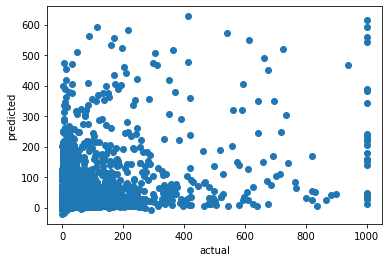

In [20]:
# 散布図を描画
plt.scatter(test_y, y_pred)
plt.xlabel("actual")
plt.ylabel("predicted")
plt.show()

In [21]:
# y_predの値が負なら0に置き換える
y_pred[y_pred < 0] = 0
# 平均絶対誤差を計算
mean_absolute_error(test_y, y_pred)

9.52789392817561

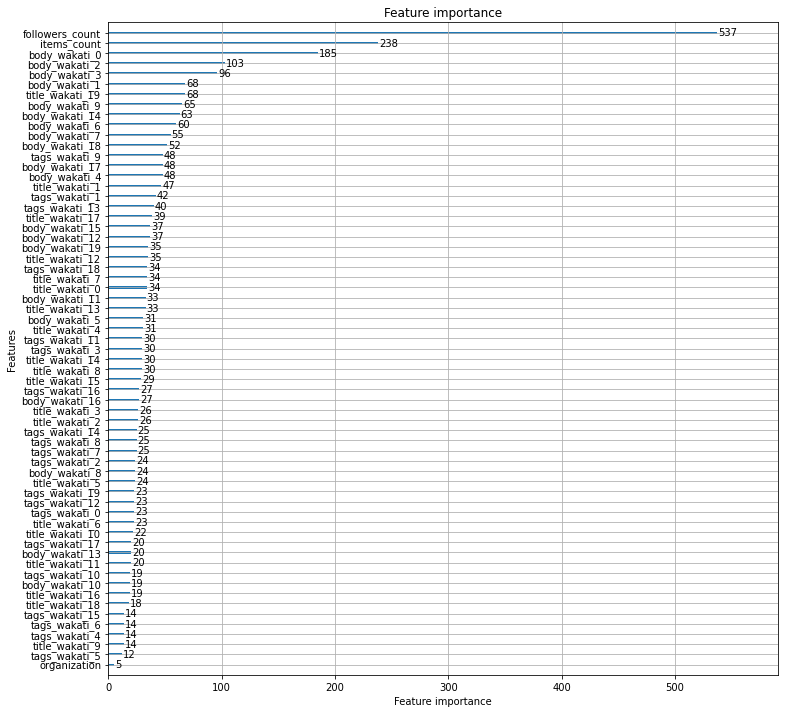

In [22]:
# 特徴量の重要度を可視化
lgb.plot_importance(model, figsize=(12, 12))
plt.show()